# 03Tools - Hyperparameter Tuning

In this notebook, BigQuery ML (BQML) is used to create a logistic regression model while using hyperparameter tuning for `L1` and `L2` regularization.

### Hyperparameter Tuning
When training a machine learning model it is helpful to find the optimal values for hyperparameters, parameters set before training begins.  These are not learned parameters like the coefficents of a model.  Rather than manually iterating these parameters we want to sequently test and focus in on optimal values.  The focusing part of the iterations is done in BQML by utilizing the [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview) service by default.

Each `MODEL_TYPE` in BQML has parameters than can be tuned as [listed here](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-hyperparameter-tuning#hyperparameters_and_objectives).  

### Prerequisites:
-  01 - BigQuery - Table Data Source

### Resources:
-  [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
-  [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)


---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
EXPERIMENT = '03a_hpt'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'
BQ_MODEL = f'{EXPERIMENT}_{BQ_DATASET}'

# Resources for serving BigQuery Model Exports
TF_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'
XGB_DEPLOY_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest'

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery
from google.cloud import aiplatform
from datetime import datetime
import matplotlib.pyplot as plt

clients:

In [4]:
bq = bigquery.Client()
aiplatform.init(project=PROJECT_ID, location=REGION)

parameters:

In [5]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
BUCKET = PROJECT_ID
URI = f"gs://{BUCKET}/{BQ_DATASET}/models/{SERIES}/{EXPERIMENT}"
RUN_NAME = f'run-{TIMESTAMP}'

---
## Train Model

Use BigQuery ML to train multiclass logistic regression model:
- [Logistic Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)
- This uses the `splits` column that notebook `01` created
- `data_split_method = CUSTOM` uses the column in `data_split_col` to assign `TRAIN`, `EVAL`, and `TEST` data splits.
    - the `CASE` statement maps the validation data to `EVAL` as expected by hyperparameter tuning (rather than `VALIDATE`)
    - note that this is different behavior for `data_split_col` with hyperparameter tuning than without hyperparameter tuning
    - hyperparameter suggestions are based on the metric calculated with the evaluation data at each intermediate step

**Hyperparameter Tuning**
The following options are added to the model training code for BQML to guide the hyperparameter tuning of `L1` and `L2` regularization:

```SQL
l1_reg = HPARAM_RANGE(0, 1000),
l2_reg = HPARAM_RANGE(0, 1000),
hparam_tuning_algorithm = 'VIZIER_DEFAULT',
hparam_tuning_objectives = ['ROC_AUC'],
num_trials = 20,
max_parallel_trials = 2
```

This instructs BQML to use the Vertex AI Vizier service to find values of `l1_reg` and `l2_reg` that optimize 'roc_auc' by doing 4 trials at a time until 20 trials have been completed.


In [6]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        enable_global_explain = TRUE,
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM',
        l1_reg = HPARAM_RANGE(0, 1000),
        l2_reg = HPARAM_RANGE(0, 1000),
        hparam_tuning_algorithm = 'VIZIER_DEFAULT',
        hparam_tuning_objectives = ['ROC_AUC'],
        num_trials = 20,
        max_parallel_trials = 2
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT.split())}, splits),
    CASE
        WHEN splits = 'VALIDATE' THEN 'EVAL'
        ELSE splits
    END AS custom_splits
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
job = bq.query(query = query)
job.result()

In [7]:
(job.ended-job.started).total_seconds()

1207.666

Add labels to the model in BigQuery:

In [8]:
model = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}')
model.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
model = bq.update_model(model, ['labels'])

Retrieve the trial info for the hyperparameter tuning:

In [9]:
trials = bq.query(
    query = f"""
        SELECT *
        FROM ML.TRIAL_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
        """
).to_dataframe()
trials

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'l1_reg': 1e-14, 'l2_reg': 1e-14}",{'roc_auc': 0.9881348651348651},0.117352,NaN,SUCCEEDED,None,False
1,2,"{'l1_reg': 3.2558270486947984e-11, 'l2_reg': 3...",{'roc_auc': 0.9881348651348651},0.117352,NaN,SUCCEEDED,None,False
2,3,"{'l1_reg': 2.2008662754153013e-07, 'l2_reg': 2...",{'roc_auc': 0.9881348651348651},0.117352,NaN,SUCCEEDED,None,False
3,4,"{'l1_reg': 1.0074806946246539e-14, 'l2_reg': 4...",{'roc_auc': 0.9881348651348651},0.117352,NaN,SUCCEEDED,None,False
4,5,"{'l1_reg': 0.006643205759563287, 'l2_reg': 7.7...",{'roc_auc': 0.9881348651348651},0.117352,NaN,SUCCEEDED,None,False
5,6,"{'l1_reg': 0.013758409896609565, 'l2_reg': 0.0...",{'roc_auc': 0.9881318681318682},0.117339,NaN,SUCCEEDED,None,False
6,7,"{'l1_reg': 3.5298990024491594e-12, 'l2_reg': 0...",{'roc_auc': 0.9881368631368631},0.117294,NaN,SUCCEEDED,None,False
7,8,"{'l1_reg': 1e-14, 'l2_reg': 8.748877316205593e...",{'roc_auc': 0.9881348651348651},0.117352,NaN,SUCCEEDED,None,False
8,9,"{'l1_reg': 5.716141224789056e-14, 'l2_reg': 10...",{'roc_auc': 0.987974025974026},0.168343,NaN,SUCCEEDED,None,False
9,10,"{'l1_reg': 3.1950482124929744e-10, 'l2_reg': 6...",{'roc_auc': 0.9881098901098901},0.111117,NaN,SUCCEEDED,None,False


### Check out this model in BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [10]:
print(f'BigQuery Console for Project:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}')

BigQuery Console for Project:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915


In [11]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfraud!3s03a_hpt_fraud


---
## Evaluate Model

### Metrics

Review the model evaluation statistics on the splits with [`ML.EVALUATE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [12]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,VALIDATE,19,0.006135,0.958333,0.736086,0.012192,0.788194,0.965930
1,TEST,19,0.006008,0.978723,0.732931,0.011942,0.733832,0.977393
2,TRAIN,19,0.006415,0.989924,0.733098,0.012748,0.747044,0.986035


### Confusion Matrix

Review the confusion matrix for each split with [`ML.CONFUSION_MATRIX`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-confusion):

In [13]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,19,0,166798,60866
1,19,1,4,393


In [14]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,19,0,20744,7452
1,19,1,2,46


In [15]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
bq.query(query = query).to_dataframe()

,trial_id,expected_label,_0,_1
0,19,0,20844,7611
1,19,1,1,46


### ROC Curve

Retrieve the ROC Curve for each split using [`ML.ROC_CURVE`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-roc):

In [16]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TRAIN')
  )
"""
train_roc = bq.query(query = query).to_dataframe()
train_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,19,1.000000,0.702771,0.000198,279,45,227619,118
1,19,0.827149,0.866499,0.008657,344,1971,225693,53
2,19,0.749170,0.894207,0.018488,355,4209,223455,42
3,19,0.682884,0.916877,0.028564,364,6503,221161,33
4,19,0.657446,0.929471,0.038306,369,8721,218943,28


In [17]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'VALIDATE')
  )
"""
val_roc = bq.query(query = query).to_dataframe()
val_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,19,1.000000,0.708333,0.000284,34,8,28188,14
1,19,0.822554,0.875000,0.008654,42,244,27952,6
2,19,0.754818,0.875000,0.018584,42,524,27672,6
3,19,0.687979,0.916667,0.028515,44,804,27392,4
4,19,0.658329,0.916667,0.038481,44,1085,27111,4


In [18]:
query = f"""
SELECT *
FROM ML.ROC_CURVE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
test_roc = bq.query(query = query).to_dataframe()
test_roc.head()

,trial_id,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,19,1.000000,0.702128,0.000176,33,5,28450,14
1,19,0.824563,0.872340,0.008575,41,244,28211,6
2,19,0.745803,0.872340,0.018626,41,530,27925,6
3,19,0.684179,0.893617,0.028607,42,814,27641,5
4,19,0.657189,0.914894,0.038658,43,1100,27355,4


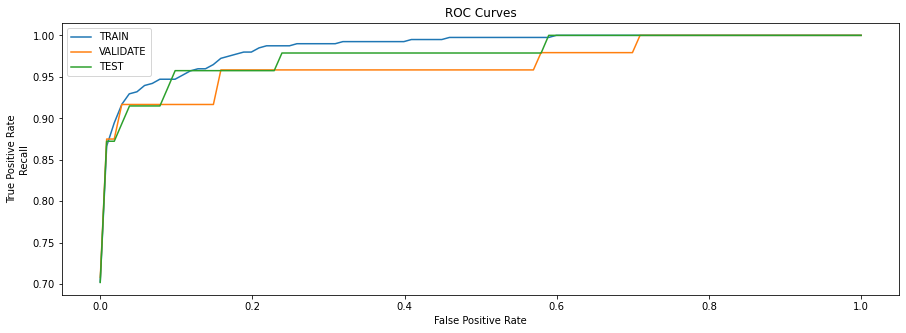

In [19]:
plt.figure(figsize=(15,5))
plt.plot(train_roc['false_positive_rate'], train_roc['recall'], label='TRAIN')
plt.plot(val_roc['false_positive_rate'], val_roc['recall'], label='VALIDATE')
plt.plot(test_roc['false_positive_rate'], test_roc['recall'], label='TEST')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate\nRecall')
plt.title('ROC Curves')
plt.legend()
plt.show()

---
## Predictions

Create a pandas dataframe with predictions for the test data in the table:

In [20]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST')
  )
"""
pred = bq.query(query = query).to_dataframe()

Review columns from the predictions - note that the query added columns with prefix `predicted_`

In [21]:
pred.columns

Index(['trial_id', 'predicted_Class', 'predicted_Class_probs', 'Time', 'V1',
       'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12',
       'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
       'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class',
       'transaction_id', 'splits'],
      dtype='object')

Print the first few rows for the columns related to the actual and predicted values:

In [22]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head()

,Class,predicted_Class,predicted_Class_probs,splits
0,0,1,"[{'label': 1, 'prob': 0.5323487014429611}, {'l...",TEST
1,0,0,"[{'label': 1, 'prob': 0.4506882028169101}, {'l...",TEST
2,0,1,"[{'label': 1, 'prob': 0.5422210252277941}, {'l...",TEST
3,0,0,"[{'label': 1, 'prob': 0.422196921304445}, {'la...",TEST
4,0,0,"[{'label': 1, 'prob': 0.42278736551536605}, {'...",TEST


Notice the nested dictionary for predicted probabilities.  In BigQuery this is a Record type structure with nested fields for `label` and `prop`.  This is returned to the pandas dataframe as a nested dictionary.

The following code sorts the dictionary for the first record by `prob`:

In [23]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 0, 'prob': 0.4676512985570389},
  {'label': 1, 'prob': 0.5323487014429611}]]

---
## Explanations
[Built-in](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview) capabilities to understand how features contributed to predictions both individually (local) and overall (global).

### Local Explainability
Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [`ML.EXPLAIN_PREDICT`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [24]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bq.query(query = query).to_dataframe()

In [25]:
explain.head()

,trial_id,predicted_Class,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Time,V1,V2,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,19,1,0.532349,"[{'feature': 'V4', 'attribution': 1.3776598376...",-0.010373,0.129576,0.0,35337,1.092844,-0.013230,...,-0.167647,0.027557,0.592115,0.219695,0.036970,0.010984,0.0,0,a1b10547-d270-48c0-b902-7a0f735dadc7,TEST
1,19,0,0.549312,"[{'feature': 'V14', 'attribution': -0.85520381...",-0.010373,-0.197890,0.0,60481,1.238973,0.035226,...,-0.057718,0.104983,0.537987,0.589563,-0.046207,-0.006212,0.0,0,814c62c8-ade4-47d5-bf83-313b0aafdee5,TEST
2,19,1,0.542221,"[{'feature': 'V4', 'attribution': 1.9618239670...",-0.010373,0.169287,0.0,139587,1.870539,0.211079,...,0.180776,-0.060226,-0.228979,0.080827,0.009868,-0.036997,0.0,0,d08a1bfa-85c5-4f1b-9537-1c5a93e6afd0,TEST
3,19,0,0.577803,"[{'feature': 'V5', 'attribution': -1.357191031...",-0.010373,-0.313761,0.0,162908,-3.368339,-1.980442,...,-1.171627,0.214333,-0.159652,-0.060883,1.294977,0.120503,0.0,0,802f3307-8e5a-4475-b795-5d5d8d7d0120,TEST
4,19,0,0.577213,"[{'feature': 'V3', 'attribution': 1.7326584256...",-0.010373,-0.311341,0.0,165236,2.180149,0.218732,...,-0.176957,0.563779,0.730183,0.707494,-0.131066,-0.090428,0.0,0,c8a5b93a-1598-4689-80be-4f9f5df0b8ce,TEST


Create a plot of feature attributions for a single prediction:

In [26]:
explanation = explain.iloc[0]['top_feature_attributions']

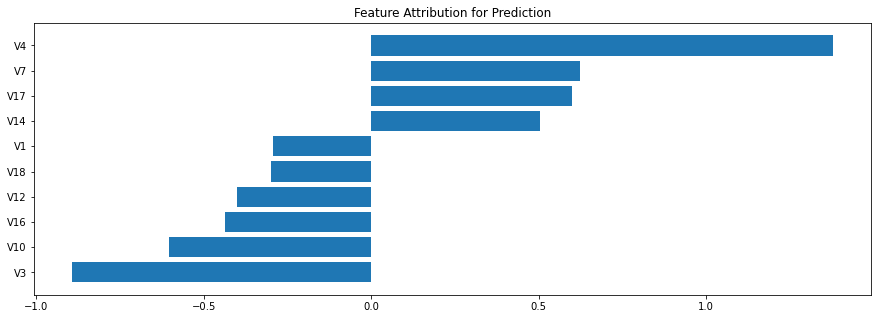

In [27]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title('Feature Attribution for Prediction')
plt.show()

### Global Explainability
Retrieve the influence of each feature on the model with [`ML.GLOBAL_EXPLAIN`](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [28]:
query = f"""
SELECT *
FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
gexplain = bq.query(query = query).to_dataframe()

In [29]:
gexplain.head()

,trial_id,feature,attribution
0,19,V17,1.147853
1,19,V14,1.031917
2,19,V12,0.970989
3,19,V16,0.768079
4,19,V3,0.753790


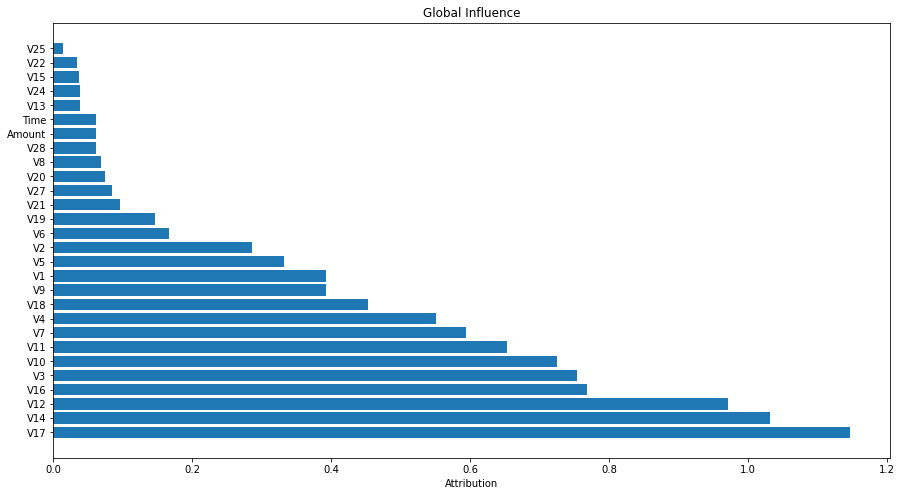

In [30]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

---
## Serving With Vertex AI

This demonstration shows the process of exporting and registering a BQML model with Vertex AI Model Registry.  To directly integrate BQML with Vertex AI Model Registry it is now (April 1, 2022) possible at model creation time with options `vertex_ai_model_id` and `vertex_ai_model_version_alises`. See the documentation for this direct integration [here](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Export the BigQuery Model

Reference: [Export the BigQuery Model](https://cloud.google.com/bigquery-ml/docs/exporting-models)

In [31]:
query = f"""
EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (URI = '{URI}/{TIMESTAMP}/model')
"""
export = bq.query(query = query)
export.result()

In [32]:
(export.ended - export.started).total_seconds()

20.817

In [33]:
listing = !gsutil ls {URI}/{TIMESTAMP}/model
listing

['gs://statmike-mlops-349915/fraud/models/03/03a_hpt/20220908175346/model/',
 'gs://statmike-mlops-349915/fraud/models/03/03a_hpt/20220908175346/model/saved_model.pb',
 'gs://statmike-mlops-349915/fraud/models/03/03a_hpt/20220908175346/model/variables/']

In [34]:
print(f"View the export in the console:\nhttps://console.cloud.google.com/storage/browser/{URI.split('//')[-1]}/{TIMESTAMP}/model?project={PROJECT_ID}")

View the export in the console:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915/fraud/models/03/03a_hpt/20220908175346/model?project=statmike-mlops-349915


### Detect The Model Types Framework

In [35]:
filetype = {'pb': 'TensorFlow', 'bst': 'XGBoost'}

filetypes = [filetype[f.split('.')[-1]] for f in listing if f.split('.')[-1] in ['pb','bst']]
if len(filetypes) == 1:
    framework = filetypes[0]
    print(f'framework = {framework}')
else:
    raise TypeError(f"Model Type Undeteremined!! Review the contents of of 'listing = {listing}'.")

framework = TensorFlow


Set the `DEPLOY_IMAGE` based on the framework:

In [36]:
if framework == 'TensorFlow':
    DEPLOY_IMAGE = TF_DEPLOY_IMAGE
elif framework == 'XGBoost':
    DEPLOY_IMAGE = XGB_DEPLOY_IMAGE
    
DEPLOY_IMAGE

'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest'

### Upload The Model To Vertex AI Model Registry
References:
- Python SDK for [`aiplatform.Model`](https://googleapis.dev/python/aiplatform/latest/aiplatform/services.html#google.cloud.aiplatform.Model)
- Python Client for [`aiplatform.Model`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [37]:
modelmatch = aiplatform.Model.list(filter = f'labels.series={SERIES} AND labels.experiment={EXPERIMENT}')

upload_model = True
if modelmatch:
    print("Model Already in Registry:")
    if RUN_NAME in modelmatch[0].version_aliases:
        print("This version already loaded, no action taken.")
        upload_model = False
        model = aiplatform.Model(model_name = modelmatch[0].resource_name)
    else:
        print('Loading model as new default version.')
        parent_model =  modelmatch[0].resource_name
else:
    print('This is a new model, creating in model registry')
    parent_model = ''

if upload_model:
    model = aiplatform.Model.upload(
        display_name = f'{EXPERIMENT}_{BQ_DATASET}',
        model_id = f'model_{EXPERIMENT}_{BQ_DATASET}',
        parent_model = parent_model,
        serving_container_image_uri = DEPLOY_IMAGE,
        artifact_uri = f"{URI}/{TIMESTAMP}/model",
        is_default_version = True,
        version_aliases = [RUN_NAME],
        version_description = RUN_NAME,
        labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}', 'run_name' : f'{RUN_NAME}', 'framework' : f'{framework.lower()}'}
    )  

This is a new model, creating in model registry
Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/model_03a_hpt_fraud/operations/3246792209722245120
Model created. Resource name: projects/1026793852137/locations/us-central1/models/3168260347622588416@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/3168260347622588416@1')


In [38]:
model.display_name

'03a_hpt_fraud'

In [39]:
model.resource_name

'projects/1026793852137/locations/us-central1/models/3168260347622588416'

In [40]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/model_{EXPERIMENT}_{BQ_DATASET}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/model_03a_hpt_fraud?project=statmike-mlops-349915


---
## Online Predictions with Vertex AI Endpoints
Check out the notebook `03Tools - Predictions` to see how to use this model with [online predictions in Vertex AI](https://cloud.google.com/vertex-ai/docs/predictions/online-predictions-custom-models).

---
## Remove Resources
see notebook "99 - Cleanup"